# Wstęp

## Wybrany temat

Tematem, dla którego przeprowadzę analizę opinii są mistrzostwa świata w piłce nożnej.
Jako źródło danych wykorzystam wpisy w języku angielskim zamieszczone na portalu [_Twitter_](https://twitter.com/) zawierające jeden z trzech _hashtagów_:

- _#fifaworldcup_
- _#worldcup_
- _#wc_

Analizowane przeze mnie wpisy bedą pochodzić z okresu od 2022-09-01 do 2023-01-31, czyli od 2 miesięcy przed mistrzostwami świata organizowanymi w Katarze do miesiąca po zakończeniu turnieju, łącznie 152 dni.
Pobranych zostanie po około 350 wpisów z każdego dnia.
Oprócz emocji sportowych wśród kibiców, temat ubiegłorocznych mistrzostw świata był również kontrowersyjny ze względu na kraj, w którym się odbyły, okres trwania turnieju (zima, w trakcie trwania sezonów ligowych zamiast tradycyjnego lata, czyli przerwy w krajowych rozgrywkach) oraz traktowania pracowników zatrudnionych do budowy stadionów i infrastruktury, wobec których łamane były prawa człowieka.

## Pobieranie danych

Analizowane przeze mnie dane zostaną pobrane z wykorzystaniem biblioteki [_snscrape_](https://github.com/JustAnotherArchivist/snscrape).
Oprócz niej, poniżej zostają zaimportowane także dwie inne biblioteki:

- [_pandas_](https://pandas.pydata.org/), używana do pracy z zebranymi danymi
- _datetime_, przydatna do pracy z datami


In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import datetime

Do pobrania danych służy zdefiniowana poniżej funkcja `scrap_tweets`.
Pobiera ona 3 parametry: informacje o ilości tweetów do pobrania z każdego dnia oraz początek i koniec okresu, z którego ma pobierać wpisy.
Najpierw pobiera ona tweety z hashtagiem _#fifaworldcup_, jeśli jest ich mniej niż rządana ilość przechodzi do hashtaga _#worldcup_, a na koniec wyszukuje wpisy pod tagiem _#wc_.
Pobrane dane zwraca w formie tabeli.


In [2]:
def scrap_tweets(max_tweets_per_day, date_from, date_to):
    tweets = []

    date_from_2 = date_from + datetime.timedelta(days=1)

    while date_from != date_to:
        query = f'#fifaworldcup lang:en since:{date_from} until:{date_from_2}'
        new_tweets = []
        for _, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
            new_tweets.append(tweet)

            if len(new_tweets) >= max_tweets_per_day:
                break

        if len(new_tweets) < max_tweets_per_day:
            query = f'#worldcup lang:en since:{date_from} until:{date_from_2}'
            for _, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
                new_tweets.append(tweet)

                if len(new_tweets) >= max_tweets_per_day:
                    break

        if len(new_tweets) < max_tweets_per_day:
            query = f'#wc lang:en since:{date_from} until:{date_from_2}'
            for _, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
                new_tweets.append(tweet)

                if len(new_tweets) >= max_tweets_per_day:
                    break

        tweets.extend(new_tweets)
        date_from += datetime.timedelta(days=1)
        date_from_2 += datetime.timedelta(days=1)

    df = pd.DataFrame(tweets)

    return df

Ponieważ pobieranie danych zajmuje dużo czasu (około 50 minut), po pobraniu tweety zostały zapisane do pliku `data_wc.csv`.
Poniżej są one z niego odczytywane w celu dalszej pracy, wyświetlona jest także ich ilość:


In [3]:
tweets = pd.read_csv("data_wc.csv", sep="\t")

print(f'Number of tweets: {len(tweets)}')

Number of tweets: 52927


Jak widać udało się zgromadzić $52927$ tweetów.
W następnym etapie zostaną one poddane przetwarzaniu w celu ułatwienia ich analizy.


# Przetwarzanie zebranych danych

## Wyodrębnienie potrzebnych informacji

Pierwszym etapem przetworzenia danych będzie wybranie z tabeli tylko potrzebnych informacji, czyli daty zamieszczenia wpisu (`date`) oraz jego zawartości (`renderedContent`).
Oprócz tego data zostanie przetworzona w taki sposób, aby zawierała informacje tylko o dniu, bez dokładnej godziny zamieszczenia tweeta.


In [4]:
tweets = tweets[["date", "renderedContent"]]

tweets["date"] = tweets.apply(
    lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d %H:%M:%S+00:00").date(), axis=1)

## Tokenizacja tweetów

Następnym etapem przygotowania danych jest tokenizacja tweetów, czyli podział każdego z nich na pojedyncze słowa (elementy, ang. token).
Wykorzystana do tego zostanie funkcja `word_tokenize` z biblioteki `nltk.tokenize`.
Tweety po tokenizacji zostaną umieszczone w tabeli w nowej kolumnie o nazwie `tokenizedContent`.


In [5]:
from nltk.tokenize import word_tokenize

tweets["tokenizedContent"] = tweets.apply(
    lambda x: word_tokenize(x["renderedContent"]), axis=1)

## Usunięcie stopwords

Kolejnym krokiem jest usunięcie "stopwords", czyli częstych słów występujących w języku nie potrzebnych do dalszej analizy, na przykład spójników.
Ponieważ wszystkie zebrane przeze mnie wpisy są napisane w języku angielskim, wykorzystam w tym celu zbiór "stopwords" dla języka angielskiego dostępnych w bibliotece `nltk.corpus`.
Przetworzone dane zostają umieszczone w tabeli w nowej kolumnie `tokensWithoutStopwords`.


In [6]:
from nltk.corpus import stopwords

chosen_stopwords = stopwords.words('english')

tweets["tokensWithoutStopwords"] = tweets.apply(lambda x: [
    word for word in x["tokenizedContent"] if word not in chosen_stopwords], axis=1)

## Lematyzacja

Ostatnim etapem będzie lematyzacja, czyli sprowadzenie wszystkich słów do ich podstawowych form. W tym celu skorzystam z obiektu klasy `WordNetLemmatizer` dostępnej w bibliotece `nltk.stem`.
Po tym etapie dane zostaną zapisane w nowej kolumnie o nazwie `lemmatizedContent`.


In [7]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tweets["lemmatizedContent"] = tweets.apply(lambda x: [lemmatizer.lemmatize(
    word) for word in x["tokensWithoutStopwords"]], axis=1)

W celu dalszej analizy wykorzystywana będzie najbardziej przetworzona kolumna danych, czyli `lemmatizedContent`.


# Analiza zebranych opinii

Po przygotowaniu danych można przystąpić do analizy zebranych wpisów.
Zostanie ona wykonana za pomocą dwóch różnych bibliotek:

- [_NLTK Vader_](https://www.nltk.org/_modules/nltk/sentiment/vader.html)
- [_Text2Emotion_](https://pypi.org/project/text2emotion/)

## Analiza za pomocą narzędzia _NLTK Vader_

Biblioteka _NLTK Vader_ umożliwia analizę tekstu pod kątem 3 różnych wskaźników: czy tekst jest pozytywny (`pos`), negatywny (`neg`), czy neutralny (`neu`).
Wskaźniki te przyjmują wartości ułamkowe i razem sumują się do wartości $1$.
Dla analizowanego tekstu biblioteka ta zwraca również wartość `compound`, wahającą się od $-1$ do $1$.
Oznacza ona ogólne nacechowanie tekstu (im mniejsza wartość, tym gorsze nastawienie autora).

### Przygotowanie danych

Poniższa funkcja `prepare_vader_data` przeprowadza analizę dla wszystkich zebranych w bazie tweetów, a następnie w odpowiednich kolumnach zapisuje otrzymane wartości dla każdego z wpisów.


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def prepare_vader_data(tweets):
    sentiment_analyzer = SentimentIntensityAnalyzer()

    vader_tweets = tweets.copy()

    vader_tweets["vaderResults"] = vader_tweets.apply(
        lambda x: sentiment_analyzer.polarity_scores(" ".join(x["lemmatizedContent"])), axis=1)

    vader_tweets["vaderNeg"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["neg"], axis=1)
    vader_tweets["vaderPos"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["pos"], axis=1)
    vader_tweets["vaderNeu"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["neu"], axis=1)
    vader_tweets["vaderCompound"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["compound"], axis=1)

    vader_tweets = vader_tweets.drop("vaderResults", axis=1)

    return vader_tweets

Ponieważ analiza, podobnie jak pobieranie danych, trwa znaczny czas, po przeanalizowaniu tweety zostały zapisane w pliku `data_wc_vader.csv`, i w dalszej części są z niego odczytywane.
Służy do tego poniższa funkcja `import_prepared_data`, która jako argument przyjmuje nazwę pliku źródłowego.
Odczytuje ona z niego dane, a następnie zapisuje je w odpowiedniej formie w tabeli (poprawne zapisanie dat oraz tablic).


In [10]:
import ast


def import_prepared_data(filename):
    prepared_data = pd.read_csv(filename, sep="\t")

    columns_to_transform = ["tokenizedContent",
                            "tokensWithoutStopwords", "lemmatizedContent"]
    for column_name in columns_to_transform:
        prepared_data[column_name] = prepared_data[column_name].apply(
            ast.literal_eval)

    prepared_data["date"] = prepared_data.apply(
        lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d").date(), axis=1)

    return prepared_data

Przeanalizowane dane zostają poniżej odczytane z pliku:


In [11]:
vader_tweets = import_prepared_data("data_wc_vader.csv")

### Analiza całościowa

Pierwszą analizą będzie analiza całościowa.
Jej pierwszym etapem będzie podział tweetów na pozytywne i negatywne.
Wybraną przeze mnie metodą podziału jest sprawdzenie, czy wskaźnik `pos` (pozytywny) przyjmuje wartość większą lub równą wskaźnikowi `neg` (negatywny).
W ten sposób ignoruje wskaźnik neutralności, i jeśli wpis jest bardziej pozytywny niż negatywny, to traktuje go jak pozytywny.
W sytuacji kiedy tweet jest tylko neutralny, również traktuje go jako wpis pozytywny.
Poniżej następuje opisany podział:


In [12]:
positive_vader_tweets = vader_tweets[vader_tweets["vaderPos"]
                                     >= vader_tweets["vaderNeg"]]

negative_vader_tweets = vader_tweets[vader_tweets["vaderPos"]
                                     < vader_tweets["vaderNeg"]]

Następnie zostaną stworzone i wyświetlone 'chmury słów' dla obu zbiorów tweetów.
Reprezentują one częstotliwość słów i wyrażeń używanych w danym zbiorze wpisów.
Do ich stworzenia wykorzystuje bibliotekę `wordcloud`, natomiast do ich wyświetlenia bibliotekę `matplotlib`.


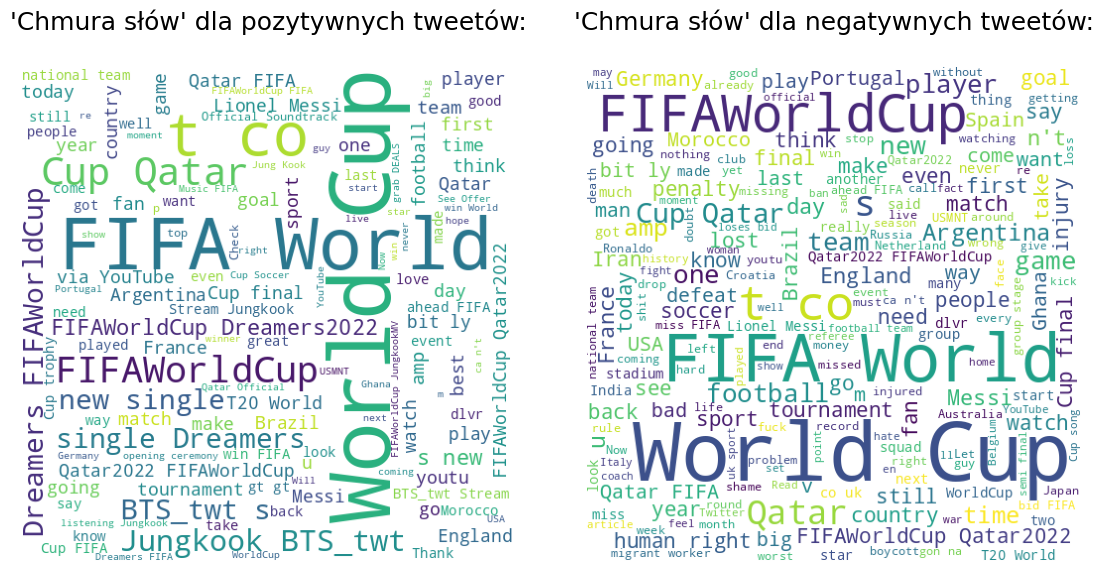

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_vader_tweets_joined_content = " ".join(
    [" ".join(word) for word in positive_vader_tweets["lemmatizedContent"]])

negative_vader_tweets_joined_content = " ".join(
    [" ".join(word) for word in negative_vader_tweets["lemmatizedContent"]])

positive_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(positive_vader_tweets_joined_content)

negative_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(negative_vader_tweets_joined_content)

fig = plt.figure(figsize=(12, 12), facecolor=None)
plt.subplot(1, 2, 1)
plt.title("'Chmura słów' dla pozytywnych tweetów:\n", fontsize=18)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=5)

plt.subplot(1, 2, 2)
plt.title("'Chmura słów' dla negatywnych tweetów:\n", fontsize=18)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=5)

plt.show()

Dla obu chmur na pierwszy rzut oka widoczne są najpopularniejsze sformułowania, takie jak _"FIFA"_, _"mistrzostwa świata"_, _"Katar"_, _"piłka nożna"_.
W obu chmurach występują także nazwy krajów, jak _Brazylia_, _Argentyna_, _Francja_, _Hiszpania_, a także nazwiska piłkarzy, jak _Lionel Messi_, który został wybrany graczem turnieju.
W chmurze pozytywnych wpisów, po lewej stronie, widoczne są także dość niespodziewane sformułowania, takie jak _"Jungkook"_, _"BTS"_ lub _"singiel Dreamers"_.
Są one związane z występem Jungkook'a, członka koreańskiego zespołu _BTS_, podczas ceremonii otwarcia mistrzostw świata w Katarze, gdzie wykonał utwór _"Dreamers"_.
Po prawej stronie natomiast, oprócz słów takich jak _"przegrana"_, _"wstyd"_, _"rzut karny"_ czy _"kontuzja"_, pojawiają się także _"prawa człowieka"_, _"śmierć"_ oraz _"bojkot"_.
Te określenia są powiązane z kwestią łamania praw człowieka wobec pracowników zatrudnionych przez Katar do pracy przy przygotowaniach do mistrzostw świata.

### Analiza czasowa

Drugą analizą będzie analiza czasowa.
Polega ona na obliczeniu średnich emocji z wpisów zebranych w poszczególnych dniach.
Następnie dane zostaną naniesione na wykresy z wykorzystaniem zdefiniowanej poniżej funkcji `plot_subplot`:


In [14]:
start_date = datetime.date(2022, 11, 20)
end_date = datetime.date(2022, 12, 18)


def plot_subplot(tweets, column_name, color, legend_name):
    plt.plot(tweets["date"],
             tweets[column_name], color=color)
    plt.plot(start_date, tweets[tweets["date"]
             == start_date][column_name], marker="o", color="purple")
    plt.plot(end_date, tweets[tweets["date"]
             == end_date][column_name], marker="o", color="deepskyblue")
    plt.ylabel("Średnia wartość")
    plt.xlabel("Data")
    plt.legend([legend_name, "Otwarcie", "Finał"])

Poniższy fragment kodu oblicza średnie emocje dla wpisów z każdego dnia, a następnie rysuje 4 wykresy odpowiadające każdemu ze wskaźników.
Na wykresach są również zaznaczone daty ceremonii otwarcia oraz finału mistrzostw świata.


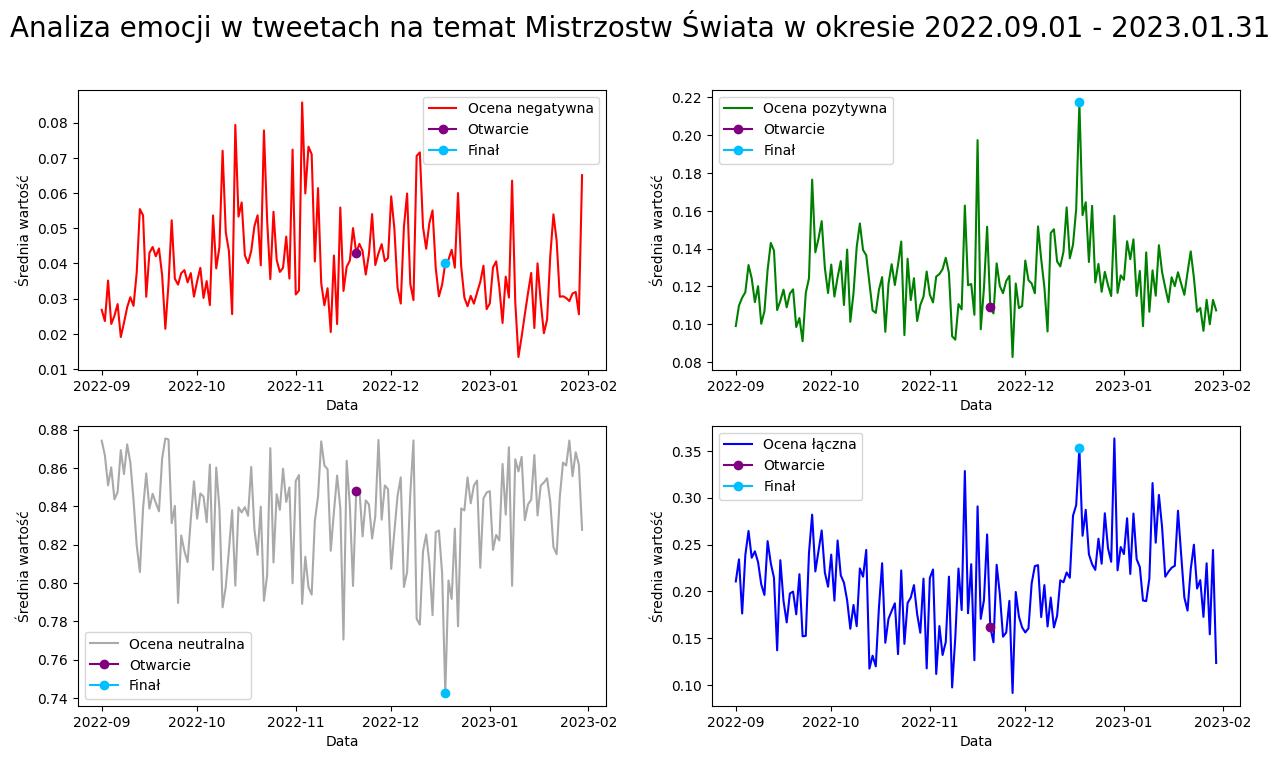

In [15]:
vader_tweets_grouped = vader_tweets[[
    "date", "vaderNeg", "vaderPos", "vaderNeu", "vaderCompound"]]

vader_tweets_means = vader_tweets_grouped.groupby(
    ["date"], as_index=False).mean()

plt.figure(figsize=(15, 8))
plt.suptitle(
    "Analiza emocji w tweetach na temat Mistrzostw Świata w okresie 2022.09.01 - 2023.01.31", fontsize=20)
plt.subplot(2, 2, 1)
plot_subplot(vader_tweets_means, "vaderNeg", "red", "Ocena negatywna")

plt.subplot(2, 2, 2)
plot_subplot(vader_tweets_means, "vaderPos", "green", "Ocena pozytywna")

plt.subplot(2, 2, 3)
plot_subplot(vader_tweets_means, "vaderNeu", "darkgrey", "Ocena neutralna")

plt.subplot(2, 2, 4)
plot_subplot(vader_tweets_means, "vaderCompound", "blue", "Ocena łączna")

plt.show()

Jak widać na powyższych wykresach, najbardziej negatywne wpisy były pisane głównie przed rozpoczęciem mistrzostw, chociaż wartości te wahały się także w trakcie ich trwania oraz po ich zakończeniu.
Na pozostałych wykresach widać wyraźnie, że najwięcej emocji przyniósł finał, określany przez ekspertów mianem najlepszego finału mistrzostw świata w historii.
W dzień finału wpisy były zdecydowanie najbardziej pozytywne oraz najmniej neutralne.
Również łączna ocena wpisów świadczy o tym, że finał budził największe emocje w trakcie mistrzostw.
Z drugiej strony widać także, że ceremonia otwarcia była dość neutralnie odbierana przez widzów, bez zbytniego zadowolenia lub niezadowolenia.

## Analiza za pomocą narzędzia _Text2Emotion_

Do drugiej analizy zostanie wykorzystania biblioteka _Text2Emotion_. Analizuje ona tekst podobnie do poprzedniego narzędzia, jednak zwraca oceny liczbowe dla 5 emocji:

- szczęścia (`Happy`)
- złości (`Angry`)
- zaskoczenia (`Surprise`)
- smutku (`Sad`)
- strachu (`Fear`)

Wobec tego analiza zostanie przeprowadzona w nieznacznie zmieniony sposób.

### Przygotowanie danych

Podobnie jak dla narzędzia `NLTK Vader`, przed przystąpieniem do analizy potrzebne jest obliczenie wartości emocji dla każdego tweetu w bazie.
Służy do tego poniższa funkcja `prepare_t2e_data`:


In [16]:
import text2emotion as te


def prepare_t2e_data(tweets):
    t2e_tweets = tweets.copy()

    t2e_tweets["t2eResults"] = t2e_tweets.apply(
        lambda x: te.get_emotion(" ".join(x["lemmatizedContent"])), axis=1)

    t2e_tweets["t2eHappy"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Happy"], axis=1)
    t2e_tweets["t2eAngry"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Angry"], axis=1)
    t2e_tweets["t2eSurprise"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Surprise"], axis=1)
    t2e_tweets["t2eSad"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Sad"], axis=1)
    t2e_tweets["t2eFear"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Fear"], axis=1)

    t2e_tweets = t2e_tweets.drop("t2eResults", axis=1)

    return t2e_tweets

[nltk_data] Downloading package stopwords to /home/wgola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wgola/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wgola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Ponieważ ponownie obliczenia zajmują dużą ilość czasu, wyniki zostały zapisane w pliku `data_wc_t2e.csv`.
Poniżej są one z niego odczytywane za pomocą funkcji `import_prepared_data`:


In [17]:
t2e_tweets = import_prepared_data("data_wc_t2e.csv")

### Analiza całościowa

W tym przypadku wpisy zostały podzielone w następujący sposób:

- jeśli suma wartości szczęścia (`Happy`) oraz zaskoczenia (`Surprise`) są większe lub równe od pozostałych danych (`Fear`, `Angry`, `Sad`), tweet jest pozytywny
- w przeciwnym przypadku tweet jest negatywny

Poniżej zostaje dokonany podział:


In [18]:
positive_t2e_tweets = t2e_tweets[t2e_tweets["t2eHappy"] + t2e_tweets["t2eSurprise"]
                                 >= t2e_tweets["t2eFear"] + t2e_tweets["t2eAngry"] + t2e_tweets["t2eSad"]]

negative_t2e_tweets = t2e_tweets[t2e_tweets["t2eHappy"] + t2e_tweets["t2eSurprise"]
                                 < t2e_tweets["t2eFear"] + t2e_tweets["t2eAngry"] + t2e_tweets["t2eSad"]]

Z wykorzystaniem powyższego podziału, poniżej tworzone i wyświetlane są 'chmury słów' dla pozytywnych i negatywnych wpisów:


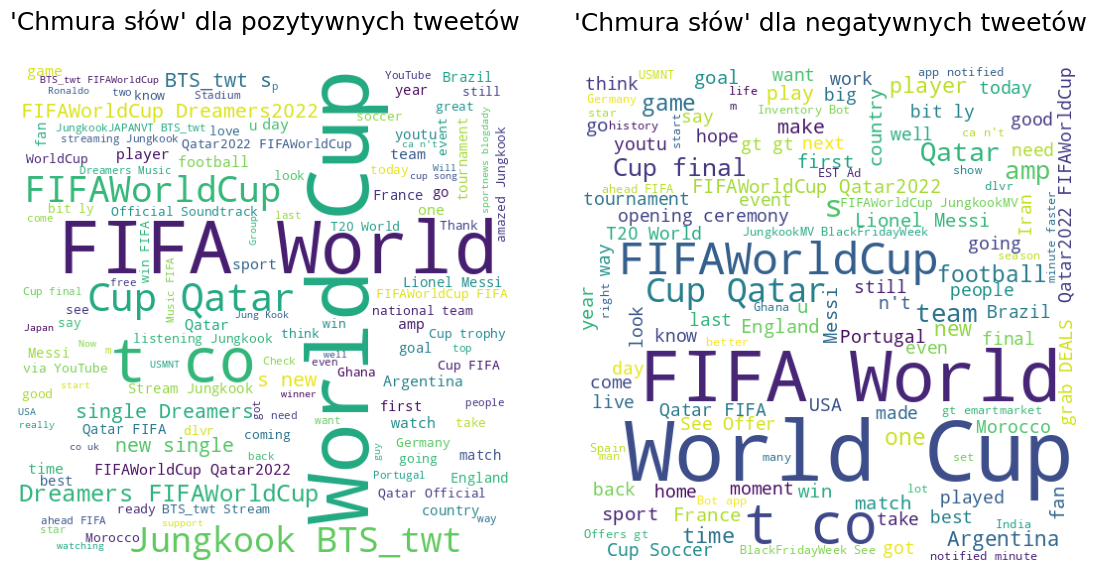

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_t2e_tweets_joined_content = " ".join(
    [" ".join(word) for word in positive_t2e_tweets["lemmatizedContent"]])

negative_t2e_tweets_joined_content = " ".join(
    [" ".join(word) for word in negative_t2e_tweets["lemmatizedContent"]])

positive_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(positive_t2e_tweets_joined_content)

negative_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(negative_t2e_tweets_joined_content)

fig = plt.figure(figsize=(12, 12), facecolor=None)

plt.subplot(1, 2, 1)
plt.title("'Chmura słów' dla pozytywnych tweetów\n", fontsize=18)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.subplot(1, 2, 2)
plt.title("'Chmura słów' dla negatywnych tweetów\n", fontsize=18)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=5)

plt.show()

W chmurze po lewej stronie, dla lepszych słów, podobnie jak w poprzednim przypadku, duża część odnosi się do występu Jungkook'a podczas ceremonii otwarcia.
Oprócz tego w obu chmurach ponownie są widocznie nazwy krajów oraz zespołów.
Po prawej stronie, dla negatywnych wpisów, oprócz wpisów podobnych do tych we wcześniej stworzonych chmurach, widocznych jest też kilka nowych sformułowań, na przykład _"ceremonia otwarcia"_.

### Analiza czasowa

W przypadku biblioteki `Text2Emotion` analiza czasowa będzie składała się z 5 wykresów, po jednym dla każdej zmierzonej emocji. Zostają one stworzone i wyświetlone poniżej z użyciem zdefiniowanej wcześniej funkcji `plot_subplot`:


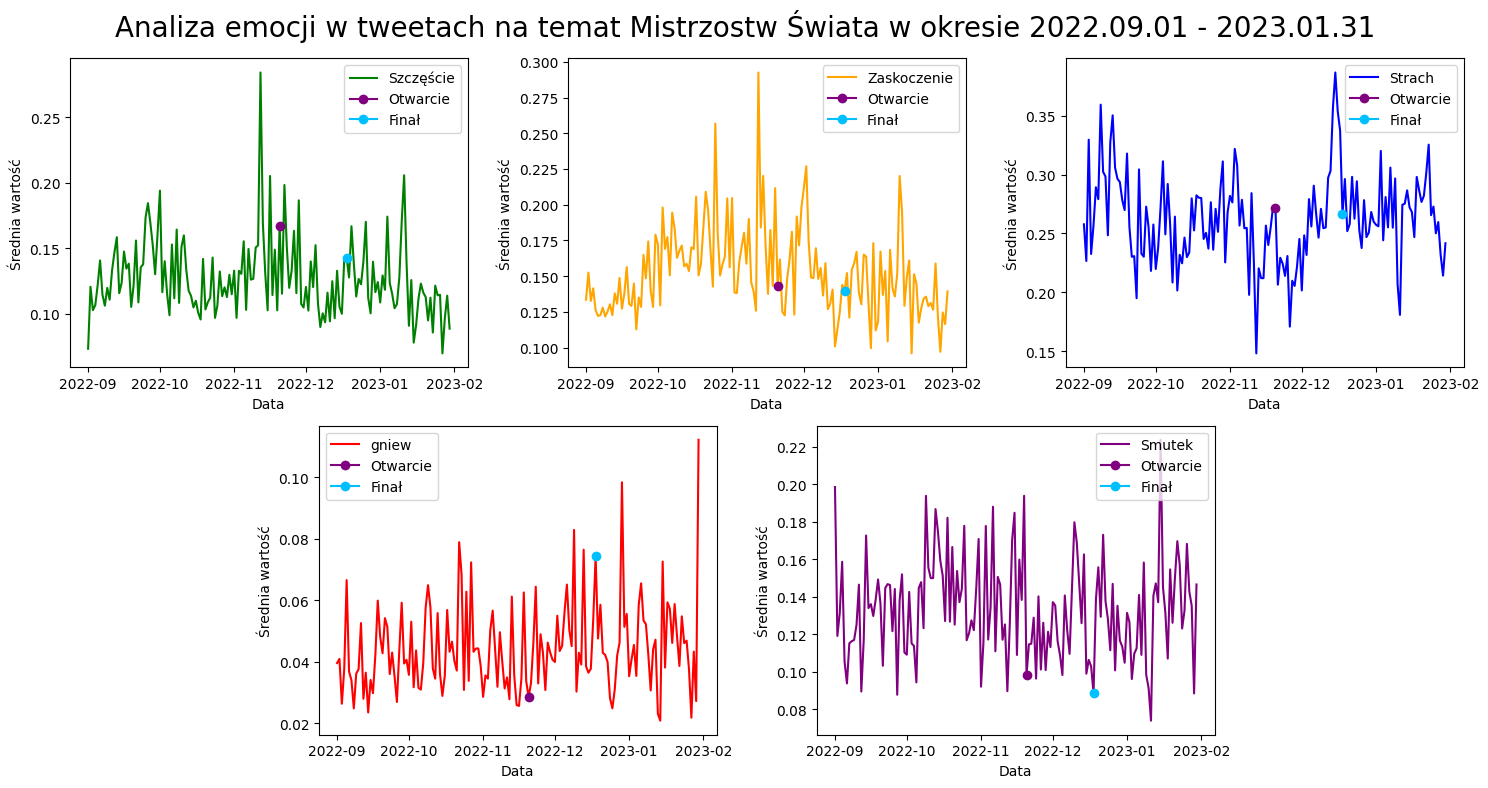

In [20]:
t2e_tweets_grouped = t2e_tweets[[
    "date", "t2eHappy", "t2eSurprise", "t2eFear", "t2eAngry", "t2eSad"]]

t2e_tweets_means = t2e_tweets_grouped.groupby(["date"], as_index=False).mean()

plt.figure(figsize=(15, 8))
plt.suptitle(
    "Analiza emocji w tweetach na temat Mistrzostw Świata w okresie 2022.09.01 - 2023.01.31", fontsize=20)
plt.subplot2grid((2, 6), (0, 0), colspan=2)
plot_subplot(t2e_tweets_means, "t2eHappy", "green", "Szczęście")

plt.subplot2grid((2, 6), (0, 2), colspan=2)
plot_subplot(t2e_tweets_means, "t2eSurprise", "orange", "Zaskoczenie")

plt.subplot2grid((2, 6), (0, 4), colspan=2)
plot_subplot(t2e_tweets_means, "t2eFear", "blue", "Strach")

plt.subplot2grid((2, 6), (1, 1), colspan=2)
plot_subplot(t2e_tweets_means, "t2eAngry", "red", "gniew")

plt.subplot2grid((2, 6), (1, 3), colspan=2)
plot_subplot(t2e_tweets_means, "t2eSad", "purple", "Smutek")

plt.tight_layout()
plt.show()

W tym przypadku wyniki są trudniejsze do zinterpretowania.
Widoczne jest, że smutek jest najniższy podczas ceremonii otwarcia oraz finału, i zmieniał się w trakcie turnieju, być może wraz z odpadaniem poszczególnych drużyn.
Wykres strachu pokazuje, że przed finałem był on największy, prawodpodobnie wśród fanów drużyn Argentyny i Francji, które się w nim zmierzyły.
Poziom gniewu był duży przed mistrzostwami, osiąga sporą wartośc w dniu finału oraz rośnie dość mocno w pojedynczych momentach po zakończeniu turnieju.
Niespodziewane wyniki natomiast przedstawiają dwa pozostałe wykresu - radości i zaskoczenia.
Wynika z nich, że największa radość, oraz największe zaskoczenie przypadły na czas przed mistrzostwami.
Z wpisów wynika, że finał nie wywołał ani dużej radości, ani dużego zaskoczenia, pomimo tego, że skończył się on rzutami karnymi po dogrywce.

# Podsumowanie

Podczas analizy tweetów widać wyraźnie, jaki wpływ na emocje kibiców miał turniej i wydarzenia podczas niego, a także przed i po nim.
Finał był wydarzeniem, które najczęściej dostarczało skrajnych emocji.
Prawdopodobnie przy analizie większej ilości wpisów, wyniki były by jeszcze bardziej wyraźne.
Podczas tworzenia chmur słów widać także, że kontrowersyjne tematy wokół mistrzostw świata w Katarze były poruszane w mediach społecznościowych i nie pozostały niezauważone przez kibiców.

# Bibliografia

- [dokumentacja biblioteki snscrape](https://github.com/JustAnotherArchivist/snscrape)
- [dokumentacja biblioteki pandas](https://pandas.pydata.org/)
- [dokumentacja biblioteki NLTK](https://www.nltk.org/)
- [dokumentacja biblioteki Text2Emotion](https://pypi.org/project/text2emotion/)
- [dokumentacja biblioteki matplotlib](https://matplotlib.org/)
- [dokumentacja biblioteki WordCloud](https://pypi.org/project/wordcloud/)
- [Mistrzostwa Świata 2022 w Katarze (Wikipedia)](https://en.wikipedia.org/wiki/2022_FIFA_World_Cup)
